In [1]:
import re
import os
import io
import ast
import gzip
import glob

import numpy as np
import pandas as pd

import torch
import pyro.distributions as dist

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from path import Path

from tqdm.notebook import tqdm

In [12]:
latent_dim_dict = {'Arizona': 5, 'Atlanta':7 , 'Baltimore':15, 'Buffalo':25, 'Carolina': 5, 'Chicago':15, 'Cincinnati':13, 'Cleveland':11, 'Dallas': 37, 'Denver':5 , 'Detroit':12, 'Green Bay': 52, 'Houston': 12, 'Indianapolis': 10, 'Jacksonville':12, 'Kansas City':11, 'Las Vegas':12, 'LA Chargers':5,'LA Rams':10, 'Miami':8, 'Minnesota':5, 'New England': 9, 'New Orleans':18 , 'NY Giants':7,'NY Jets':7, 'Philadelphia':10, 'Pittsburgh': 25, 'San Francisco': 12, 'Seattle': 14, 'Tampa Bay': 15, 'Tennessee': 13, 'Washington':4}
grouped_df = pd.read_csv('Grouped_df.csv')
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

# results_dir = Path('/net/projects/schein-lab/jshou/Posterior_Checks/Indianapolis/')
results_dir = Path('.')
posterior_samples = torch.load(results_dir.joinpath('GAP_posterior_samples_None_01_latent_dim_15.pth'))
Z_samples = np.array(posterior_samples['Z'])
latent_dim, n_counties = Z_samples[0].shape

data_dir = Path('dat')
team = 'Indianapolis'
train_data = torch.load(data_dir.joinpath(team, 'train_data.pt')).clamp(min=0)  # why is this necessary?
test_data = torch.load(data_dir.joinpath(team, 'test_data.pt')).clamp(min=0)
train_data, test_data = np.array(train_data), np.array(test_data)
assert train_data.shape[1] == test_data.shape[1] == n_counties

assert np.allclose(test_data, train_data) # why are these the same?

intervention_day = 100 # create test data from this day onwards
test_data = test_data[intervention_day:]

In [13]:
def get_reg_arrays(Z, outcomes, intervention_day, counterfactual=False, include_previous_outcome=False):
    latent_dim, n_counties = Z.shape
    assert outcomes.shape[0] == n_counties

    A = np.zeros((n_counties, 1))
    if not counterfactual:
        A[-1] = 1
    
    if include_previous_outcome:
        B = np.array(outcomes[:, intervention_day-1])[:, np.newaxis]
        X = np.concatenate([Z.T, B, A], axis=1)
        assert X.shape == (n_counties, latent_dim + 2)
    else:
        X = np.concatenate([Z.T, A], axis=1)
        assert X.shape == (n_counties, latent_dim + 1)

    Y = np.array(outcomes[:, intervention_day:])
    return X, Y


def get_counterfactual_from_best_reg(Z, outcomes, intervention_day, include_previous_outcome=True,
                                     reg_type='Ridge', reg_params={"alpha": [0, 1e-4,1e-3, 1e-2]}):
    
    X, Y = get_reg_arrays(Z, outcomes, intervention_day, include_previous_outcome=include_previous_outcome)

    if reg_type == 'Ridge':
        reg = Ridge()
    elif reg_type == 'MLP': 
        reg = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=5000)
    elif reg_type == 'Lasso':
        reg = Lasso()
    
    cv = GridSearchCV(reg, reg_params, scoring='r2', cv=5)
    cv_results = cv.fit(X, Y)
    best_reg = cv_results.best_estimator_

    X, _ = get_reg_arrays(Z, outcomes, intervention_day, include_previous_outcome=include_previous_outcome, counterfactual=True)
    return best_reg.predict(X)[-1], best_reg  # return only affected county and model

cf_preds = []
for Z in tqdm(Z_samples):
    cf_pred, _ = get_counterfactual_from_best_reg(Z, outcomes=train_data.T, intervention_day=100, include_previous_outcome=True)
    cf_preds.append(cf_pred)
cf_preds = np.array(cf_preds)

  0%|          | 0/2000 [00:00<?, ?it/s]

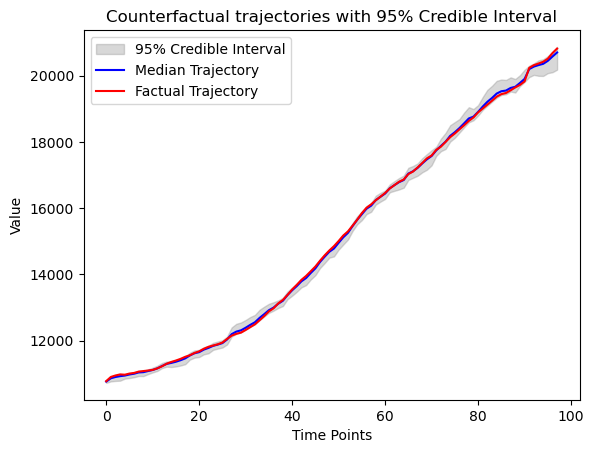

In [14]:

# Compute percentiles and median across trajectories for each time point
lower_bound = np.percentile(cf_preds, 2.5, axis=0)
upper_bound = np.percentile(cf_preds, 97.5, axis=0)
median_trajectory = np.median(cf_preds, axis=0)

time_points = np.arange(cf_preds.shape[1])
plt.fill_between(time_points, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Credible Interval')
plt.plot(time_points, median_trajectory, 'b-', label='Median Trajectory')
plt.plot(time_points, test_data[:, -1], 'r-', label='Factual Trajectory')
plt.legend()
plt.title('Counterfactual trajectories with 95% Credible Interval')
plt.xlabel('Time Points')
plt.ylabel('Value')
plt.show()

In [44]:
counterfactual_x = x_regressors
counterfactual_x[w_counties-1, latent_dim] = 0 #Set "stadium open status" to 0.

if regression_type == 'MLP':
    counterfactual_outcome = deconfound_lin_reg.predict(counterfactual_x)
elif regression_type in ['Ridge', 'Lasso']:
    coefficients = torch.tensor(deconfound_lin_reg.coef_)

    assert coefficients.shape[1] == latent_dim + 1
    assert coefficients.shape[0] == post_intervention_days


    #Now, we perform reconstruction for the deconfounded counterfactual result by setting A=0 for the 
    #stadium county .

    #coefficients = coefficients.float()

    counterfactual_outcome = counterfactual_x @ coefficients.clone().detach().transpose(0, 1)

assert counterfactual_outcome.shape == Y.transpose(0,1).shape
counterfactual_outcomes_deconfound.append(counterfactual_outcome)

Ridge(alpha=0.01)

In [23]:
def synthetic_control(Z_samples, train_data, test_data, dates):
    n_pre_intervention_days, n_counties = train_data.shape
    n_post_intervention_days, n_counties = test_data.shape

    latent_dim = Z_samples[0].shape[0]
    assert Z_samples[0].shape == (latent_dim, n_counties)
    
    #Store results for different synthetic control regressions, as we iterate through W_samples
    counterfactual_outcomes_deconfound = []
    time_step_outcomes = []

    A = np.zeros(n_counties)
    A[-1] = 1
    A = A.reshape(1, n_counties) # why?
    
    for Z_sample in Z_samples: 
    
        #Run Regression with latent_p W_sample on Y_it, for each timestep t post intervention. 
        
        #Add [1] if it is intervention
        
        #Serialize the arrays for the plots. Save to disk the files. 
        #An array that is RBSC, array that is 2000 trajectories, array that is test data, k=9, etc etc etc, actual posterior samples used
        #Create folder called replication. Some files for every county. all 2000 posterior, RBSC predictions. counterfactual. 
        #Within each county, another subfolder that for GAP, PPCA, k_5, k_10

        #After folders, create jupyter notebook that goes through the directories, pulls through right arrays, then calculates causal effects.
        #FLAG use this model for this county. 

        #ATT results. 

            
        x_regressors = torch.cat((W_sample, A), dim=0).transpose(0,1)
        
        assert x_regressors.shape == (w_counties, latent_dim + 1)

        #For Yit ~ Ai + Yi(-m) + … + Yi(-1), ,we need stadium data pre intervention, which is just stadium train

        Y = test_data

        assert Y.shape == (post_intervention_days,  w_counties)

        test_data_array = np.array(test_data)
        stadium_test = test_data_array[:, -1]
        train_data_array = np.array(train_data)
        stadium_train = train_data_array[:, -1]

        #Try Ridge, Lasso, MLP Regression ,with Cross Validation to find best value. 
        
        #Parameters for GridsearchCV for Lasso and Ridge
        parameters = {"alpha": [0, 1e-4,1e-3, 1e-2]}
        if regression_type == 'Ridge':
            reg = Ridge()
            clf = GridSearchCV(reg, parameters, scoring='r2', cv=5)
        elif regression_type == 'MLP': 
            clf = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=5000)
        elif regression_type == 'Lasso':
            reg = Lasso()
            #parameters = {'alpha': [0.01]}
            #Right now 0.01 working best for lasso
            clf = GridSearchCV(reg, parameters, scoring = 'r2', cv=5)
            
        deconfound_lin_reg = clf.fit(x_regressors, Y.transpose(0,1))
        deconfound_lin_reg = clf.best_estimator_
        
        counterfactual_x = x_regressors
        counterfactual_x[w_counties-1, latent_dim] = 0 #Set "stadium open status" to 0.
        
        if regression_type == 'MLP':
            counterfactual_outcome = deconfound_lin_reg.predict(counterfactual_x)
        elif regression_type in ['Ridge', 'Lasso']:
            coefficients = torch.tensor(deconfound_lin_reg.coef_)
        
            assert coefficients.shape[1] == latent_dim + 1
            assert coefficients.shape[0] == post_intervention_days


            #Now, we perform reconstruction for the deconfounded counterfactual result by setting A=0 for the 
            #stadium county .

            #coefficients = coefficients.float()

            counterfactual_outcome = counterfactual_x @ coefficients.clone().detach().transpose(0, 1)
        
        assert counterfactual_outcome.shape == Y.transpose(0,1).shape
        counterfactual_outcomes_deconfound.append(counterfactual_outcome)
    
    if regression_type in ['Ridge', 'Lasso']:
        stadium_cf_deconfound = [counterfactuals[-1, :].numpy() for counterfactuals in counterfactual_outcomes_deconfound]
    else:
        stadium_cf_deconfound = [counterfactuals[-1, :] for counterfactuals in counterfactual_outcomes_deconfound]
    
    percentiles_5 = np.percentile(stadium_cf_deconfound, 5, axis=0)
    percentiles_95 = np.percentile(stadium_cf_deconfound, 95, axis=0)
    
    #print(stadium_cf_deconfound)
    median_values = np.median(stadium_cf_deconfound, axis=0)

    
    post_dates = dates[-post_intervention_days:]['date']
    post_dates_list = [pd.Timestamp(date).to_pydatetime() for date in post_dates]
    plt.fill_between(post_dates_list, percentiles_5, percentiles_95, color='gray', alpha=0.3, label='5th-95th Percentile Range')
    pre_dates = dates[:pre_intervention_days]['date']
    plt.plot(post_dates_list, median_values, label='Bayesian Synthetic Control Median Values ' + str(regression_type) + ' '+ str(team))
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', which='major')

    plt.plot(post_dates.values, stadium_test, label = 'Stadium Data Postintervention')
    plt.plot(pre_dates.values, stadium_train, label = 'Stadium Data Pre-intervention')
    plt.axvline(x=dates['date'].iloc[pre_intervention_days], color='grey')

    
    plt.plot(dates.values, RBSC, label = 'Robust Synthetic Control')
    plt.title('Synthetic Control ' + str(team) + " with number of latents " + str(W_samples[0].shape[0]) + " and counties " + str(W_samples[0].shape[1]) +" and number of samples " + str(len(W_samples)))
    plt.legend()
    #Save plot figure

    if save_fig:
        plt.gcf().set_size_inches(10, 6)  # Set the figure size (width, height)
        plt.tight_layout() 
        folder = graphs_dir

        save_name = f'{team}_{latent_dim}_plot.png'
        save_path = os.path.join(folder, save_name)
        plt.savefig(save_path)
        
    if show_plot:
        plt.show()

    
    return median_values


def bayesian_SC_graph(team_county_data):
    count = 0
    for i, (team, county, state, date) in enumerate(team_county_data):
        count += 1
        date = ast.literal_eval(date)
        #team = ast.literal_eval(team)
        county = ast.literal_eval(county)
        state = ast.literal_eval(state)
        if team == 'Indianapolis':  #Ignore Arizona
            print(team)

            #Load Training and test data
            synthetic_control_training_path = os.path.join(train_dir, team, 'train_data.pt')
            synthetic_control_testing_path = os.path.join(train_dir, team, 'test_data.pt')
            synthetic_control_training = torch.load(synthetic_control_training_path)
            synthetic_control_testing = torch.load(synthetic_control_testing_path)

            #Produce Confounder variable to use in our regression
            #Run Poisson Factorization Model

            latent_dimension = 5#best_models[team]

            #Can edit masking below for type of check. 
            #h_samples, z_samples = os.path.join(results_dir, team)

            
            posterior_samples = indianapolis_samples
            #posterior_samples = load_compressed_dict(f'/net/projects/schein-lab/jshou/Population_Checks/{team}/GAP_posterior_samples_Speckled_02_latent_dim_{latent_dimension}.pth.gz')
            #posterior_samples = load_compressed_dict(f'/net/projects/schein-lab/jshou/Population_Checks/{team}/GAP_posterior_samples_Speckled_05_latent_dim_{latent_dimension}.pth.gz')


            
            synthetic_control_training = synthetic_control_training.clamp(min=0)
            RBSC_results = torch.load(f'RBSC_Replications/{team}/train_data.pt')
            z_samples = posterior_samples['Z']
            dates = pd.read_csv(os.path.join(train_dir, team, 'dates.csv'), parse_dates=['date'])

            deconfounders_ridge = Synthetic_control(z_samples, synthetic_control_training, synthetic_control_testing, dates, team, RBSC_results, regression_type='Ridge',  save_fig=False, show_plot = True)
            #deconfounders_lasso = Synthetic_control(z_samples, synthetic_control_training, synthetic_control_testing, dates, team, RBSC_results, regression_type='Lasso', show_plot = True)

    return deconfounders_ridge

bayesian_SC_graph(zipped_input)


Indianapolis


FileNotFoundError: [Errno 2] No such file or directory: 'RBSC_Replications/Indianapolis/train_data.pt'

Indianapolis


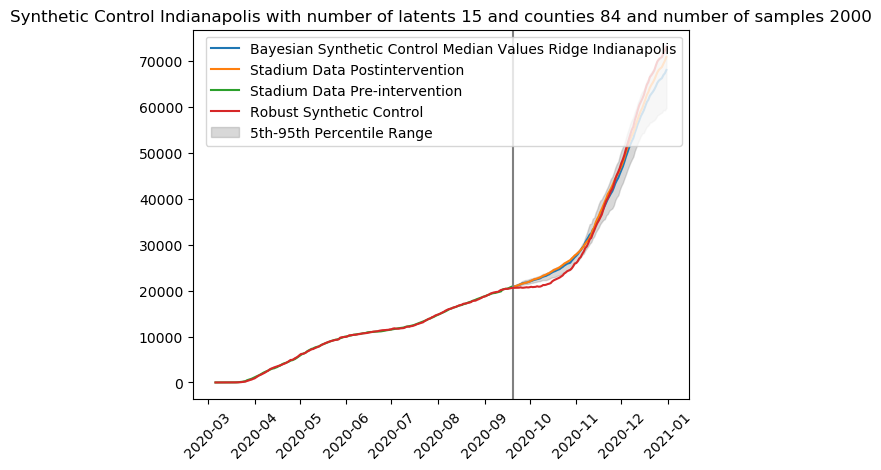

array([20830.89649358, 20905.60327589, 20984.04834958, 21090.23521302,
       21235.44032742, 21380.42448151, 21559.72749316, 21618.0801384 ,
       21709.74045353, 21742.98840234, 21828.34031441, 21942.06182789,
       22074.00278374, 22185.4210689 , 22327.87180676, 22387.57710276,
       22486.63709214, 22558.94339741, 22655.01822032, 22859.73261674,
       23006.39000386, 23116.79331283, 23204.86689567, 23399.58793676,
       23519.38430525, 23761.53114229, 23950.87059119, 24120.45529028,
       24227.93597478, 24396.66602852, 24543.63267938, 24674.97090305,
       24930.76705927, 25136.73737852, 25422.88483309, 25625.32952346,
       25835.69625514, 25941.05669878, 26040.56962805, 26491.07061405,
       26851.14831447, 27245.38448208, 27537.73054914, 27900.69291327,
       28349.13577141, 28758.8512317 , 29298.45020135, 29661.58065317,
       30456.77772828, 31024.05378548, 31559.23393062, 32170.59053436,
       32425.14905401, 33215.71030556, 33576.73414894, 34519.02706456,
      

In [16]:
train_dir = 'dat'

latent_dim_dict = {'Arizona': 5, 'Atlanta':7 , 'Baltimore':15, 'Buffalo':25, 'Carolina': 5, 'Chicago':15, 'Cincinnati':13, 'Cleveland':11, 'Dallas': 37, 'Denver':5 , 'Detroit':12, 'Green Bay': 52, 'Houston': 12, 'Indianapolis': 10, 'Jacksonville':12, 'Kansas City':11, 'Las Vegas':12, 'LA Chargers':5,'LA Rams':10, 'Miami':8, 'Minnesota':5, 'New England': 9, 'New Orleans':18 , 'NY Giants':7,'NY Jets':7, 'Philadelphia':10, 'Pittsburgh': 25, 'San Francisco': 12, 'Seattle': 14, 'Tampa Bay': 15, 'Tennessee': 13, 'Washington':4}

grouped_df = pd.read_csv('Grouped_df.csv')

zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

indianapolis_samples = torch.load('/net/projects/schein-lab/jshou/Posterior_Checks/Indianapolis/GAP_posterior_samples_None_01_latent_dim_5.pth')

#indianapolis_samples = torch.load('/net/projects/schein-lab/jshou/Posterior_Checks/Indianapolis/GAP_PPOST_None_mask_01_latent_10.pth')



indianapolis_samples = torch.load('/net/projects/schein-lab/jshou/Posterior_Checks/Indianapolis/GAP_posterior_samples_None_01_latent_dim_15.pth')
bayesian_SC_graph(zipped_input)